In [1]:
import os
os.chdir("..")
import numpy as np
from CPSL_Radar.Analyzer import Analyzer
from CPSL_Radar.datasets.Dataset_Generator import DatasetGenerator
from torchvision import transforms

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#initialize the dataset generator
drone_folder = "/home/david/CPSL_Drone/"
# test_scenarios = ["drone_test"]

# test_scenarios = [os.path.join(drone_folder,scenario_folder) for
#                   scenario_folder in test_scenarios]

scenarios_to_use = [drone_folder]

#location that we wish to save the dataset to
generated_dataset_path = "/home/david/CPSL_Drone/test/"

#specifying the names for the files
generated_file_name = "frame"
radar_data_folder = "radar"

#basic dataset settings
num_chirps_to_save = 40
num_previous_frames = 0
use_average_range_az = False

#initialize the DatasetGenerator
dataset_generator = DatasetGenerator(radar_data_only=True)

dataset_generator.config_generated_dataset_paths(
    generated_dataset_path=generated_dataset_path,
    generated_file_name=generated_file_name,
    generated_radar_data_folder=radar_data_folder,
    generated_lidar_data_folder=None,
    clear_existing_data=False
)

dataset_generator.config_radar_lidar_data_paths(
    scenario_folder= scenarios_to_use[0],
    radar_data_folder=radar_data_folder,
    lidar_data_folder=None
)

#configure the radar data processor
dataset_generator.config_radar_data_processor(
    max_range_bin=64,
    num_chirps_to_save=num_chirps_to_save,
    num_previous_frames=num_previous_frames,
    use_average_range_az=use_average_range_az,
    radar_fov= [-0.87, 0.87], #+/- 50 degrees
    num_angle_bins=64,
    power_range_dB=[60,105],
    chirps_per_frame= 64,
    rx_channels = 4,
    tx_channels = 1,
    samples_per_chirp = 64,
    adc_sample_rate_Hz = 2e6,
    chirp_slope_MHz_us= 35,
    start_freq_Hz=77e9,
    idle_time_us = 100,
    ramp_end_time_us = 100
)

#configure the lidar data processor
dataset_generator.config_lidar_data_processor(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[-np.pi/2 - 0.87,-np.pi/2 + 0.87], #[-np.pi /2 , np.pi /2],
    num_angle_bins=48,
    num_previous_frames=num_previous_frames
)

DatasetGenerator._check_for_directory: found directory /home/david/CPSL_Drone/test/
DatasetGenerator._check_for_directory: found directory /home/david/CPSL_Drone/test/radar
DatasetGenerator.config_radar_lidar_data_paths: found 1848 samples
max range: 8.5654988m
num actual angle bins: 48
DatasetGenerator.config_lidar_data_processor:lidar data processor configured, but dataset generator initialize for radar data only


In [3]:
#generate the test dataset if needed

#USE THIS ONE FOR NOW
# dataset_generator.generate_dataset_from_multiple_scenarios(
#     scenario_folders = scenarios_to_use,
#     radar_data_folder= radar_data_folder,
#     lidar_data_folder=None
# )

In [4]:
from CPSL_Radar.models.unet import unet

#initialize the transforms
unet_transforms = [
    transforms.ToTensor(),
    transforms.Resize((64,48))
]

#initialize the unet
unet_model = unet(
    encoder_input_channels= 40,
    encoder_out_channels= (64,128,256),
    decoder_input_channels= (512,256,128),
    decoder_out_channels= 64,
    output_channels= 1,
    retain_dimmension= False,
    input_dimmensions= (64,48)
)

#initialize the viewer
result_analyzer = Analyzer(
    dataset_generator=dataset_generator,
    model=unet_model,
    transforms_to_apply= unet_transforms,
    working_dir="working_dir/",
    model_state_dict_file_name="trained_campus_chirps_smaller.pth",
    cuda_device="cuda:0"
)

Analyzer.__init__: using GPU: cuda:0


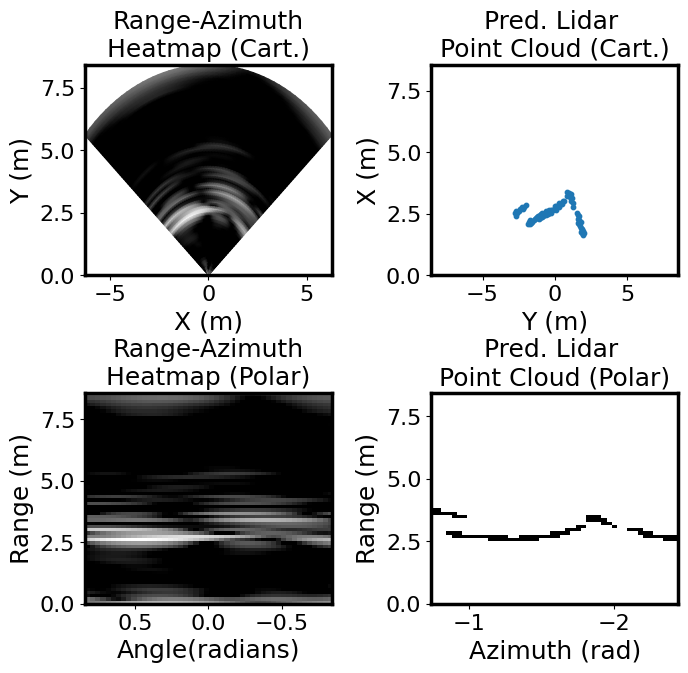

In [5]:
#show the results for a given sample
result_analyzer.view_result(sample_idx=283)